# 02 - Data Cleaning & CLAHE Enhancement

**Author:** Tan Ming Kai (24PMR12003)  
**Date:** 2025-11-10  
**Purpose:** Apply CLAHE enhancement and validate image quality

**Project:** Multi-Scale Vision Transformer (CrossViT) for COVID-19 Chest X-ray Classification  
**Academic Year:** 2025/26

---

## Objectives
1. ✅ Load image paths from CSV files created in notebook 01
2. ✅ Apply CLAHE enhancement (clipLimit=2.0, tileGridSize=(8,8))
3. ✅ Validate image quality and detect corrupted files
4. ✅ Resize images to 240×240 for CrossViT
5. ✅ Convert grayscale to RGB (3 channels)
6. ✅ Save preprocessed images to `data/processed/`
7. ✅ Generate before/after comparison visualizations

---

## CRISP-DM Phase: Data Preparation (Phase 2)

This notebook implements data cleaning and preprocessing as part of the CRISP-DM methodology.

## 1. Reproducibility Setup & Imports

**CRITICAL:** Load reproducibility seeds and required libraries.

In [1]:
"""
Data Cleaning Notebook for CrossViT COVID-19 FYP
Author: Tan Ming Kai (24PMR12003)
Purpose: Apply CLAHE enhancement and validate image quality
"""

# ============================================================================
# 1. REPRODUCIBILITY SETUP (ALWAYS FIRST!)
# ============================================================================
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ Random seeds set to 42 for reproducibility")

# ============================================================================
# 2. STANDARD LIBRARY IMPORTS
# ============================================================================
import os
import sys
from pathlib import Path
import warnings
import shutil
warnings.filterwarnings('ignore')

# ============================================================================
# 3. DATA SCIENCE LIBRARIES
# ============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# ============================================================================
# 4. COMPUTER VISION LIBRARIES
# ============================================================================
import cv2
from PIL import Image

print("\n✅ All imports successful!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"OpenCV version: {cv2.__version__}")

✅ Random seeds set to 42 for reproducibility

✅ All imports successful!
NumPy version: 2.2.6
Pandas version: 2.3.3
OpenCV version: 4.12.0


## 2. Configuration

Define paths and CLAHE parameters.

In [2]:
# Paths
CSV_DIR = Path("../data/processed")
OUTPUT_DIR = Path("../data/processed/clahe_enhanced")

# CLAHE parameters (DO NOT MODIFY - specified in CLAUDE.md)
CLAHE_CLIP_LIMIT = 2.0
CLAHE_TILE_GRID_SIZE = (8, 8)

# Target image size for CrossViT
TARGET_SIZE = (240, 240)

# Create output directories
for split in ['train', 'val', 'test']:
    for class_name in ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']:
        output_path = OUTPUT_DIR / split / class_name
        output_path.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("CONFIGURATION")
print("=" * 70)
print(f"\n📂 Input CSV Directory: {CSV_DIR.absolute()}")
print(f"📂 Output Directory: {OUTPUT_DIR.absolute()}")
print(f"\n🔧 CLAHE Parameters:")
print(f"   - Clip Limit: {CLAHE_CLIP_LIMIT}")
print(f"   - Tile Grid Size: {CLAHE_TILE_GRID_SIZE}")
print(f"\n📐 Target Image Size: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print(f"\n✅ Output directories created")
print("=" * 70)

CONFIGURATION

📂 Input CSV Directory: d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed
📂 Output Directory: d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced

🔧 CLAHE Parameters:
   - Clip Limit: 2.0
   - Tile Grid Size: (8, 8)

📐 Target Image Size: 240×240

✅ Output directories created


## 3. Load CSV Files

Load the train, val, and test splits created in notebook 01.

In [3]:
print("=" * 70)
print("LOADING CSV FILES")
print("=" * 70)

# Load CSV files
train_df = pd.read_csv(CSV_DIR / "train.csv")
val_df = pd.read_csv(CSV_DIR / "val.csv")
test_df = pd.read_csv(CSV_DIR / "test.csv")

print(f"\n✅ CSV files loaded:")
print(f"   - Train: {len(train_df):,} images")
print(f"   - Val:   {len(val_df):,} images")
print(f"   - Test:  {len(test_df):,} images")
print(f"   - Total: {len(train_df) + len(val_df) + len(test_df):,} images")

print("\n📋 Sample from train set:")
print(train_df.head())

print("\n" + "=" * 70)

LOADING CSV FILES

✅ CSV files loaded:
   - Train: 16,931 images
   - Val:   2,117 images
   - Test:  2,117 images
   - Total: 21,165 images

📋 Sample from train set:
                                          image_path  label    class_name  \
0  d:\Users\USER\Documents\GitHub\fyp-project\FYP...      2  Lung_Opacity   
1  d:\Users\USER\Documents\GitHub\fyp-project\FYP...      1        Normal   
2  d:\Users\USER\Documents\GitHub\fyp-project\FYP...      2  Lung_Opacity   
3  d:\Users\USER\Documents\GitHub\fyp-project\FYP...      2  Lung_Opacity   
4  d:\Users\USER\Documents\GitHub\fyp-project\FYP...      1        Normal   

   split  
0  train  
1  train  
2  train  
3  train  
4  train  



## 4. Define CLAHE Enhancement Function

Create preprocessing function following EXACT specifications from CLAUDE.md.

In [4]:
def preprocess_image(image_path, clahe_clip=CLAHE_CLIP_LIMIT, tile_size=CLAHE_TILE_GRID_SIZE, target_size=TARGET_SIZE):
    """
    Apply CLAHE enhancement and preprocessing to chest X-ray image.
    
    Pipeline:
    1. Load image in grayscale
    2. Apply CLAHE enhancement
    3. Resize to target size (240×240)
    4. Convert grayscale to RGB (3 channels for CrossViT)
    
    Args:
        image_path (str): Path to input image
        clahe_clip (float): CLAHE clip limit (default: 2.0)
        tile_size (tuple): CLAHE tile grid size (default: (8, 8))
        target_size (tuple): Target image dimensions (default: (240, 240))
    
    Returns:
        tuple: (rgb_image, success_flag, error_message)
    """
    try:
        # 1. Load image in grayscale
        img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            return None, False, "Failed to load image"
        
        # 2. Apply CLAHE enhancement
        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=tile_size)
        enhanced = clahe.apply(img)
        
        # 3. Resize to target size
        resized = cv2.resize(enhanced, target_size, interpolation=cv2.INTER_AREA)
        
        # 4. Convert grayscale to RGB (CrossViT requires 3 channels)
        rgb_image = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
        
        return rgb_image, True, None
        
    except Exception as e:
        return None, False, str(e)


print("✅ CLAHE preprocessing function defined")
print("\n📝 Pipeline Steps:")
print("   1. Load image in grayscale")
print(f"   2. Apply CLAHE (clip={CLAHE_CLIP_LIMIT}, tile={CLAHE_TILE_GRID_SIZE})")
print(f"   3. Resize to {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   4. Convert to RGB (3 channels)")

✅ CLAHE preprocessing function defined

📝 Pipeline Steps:
   1. Load image in grayscale
   2. Apply CLAHE (clip=2.0, tile=(8, 8))
   3. Resize to 240×240
   4. Convert to RGB (3 channels)


## 5. Test CLAHE Enhancement on Sample Images

Visualize before/after comparison for quality check.

TESTING CLAHE ENHANCEMENT


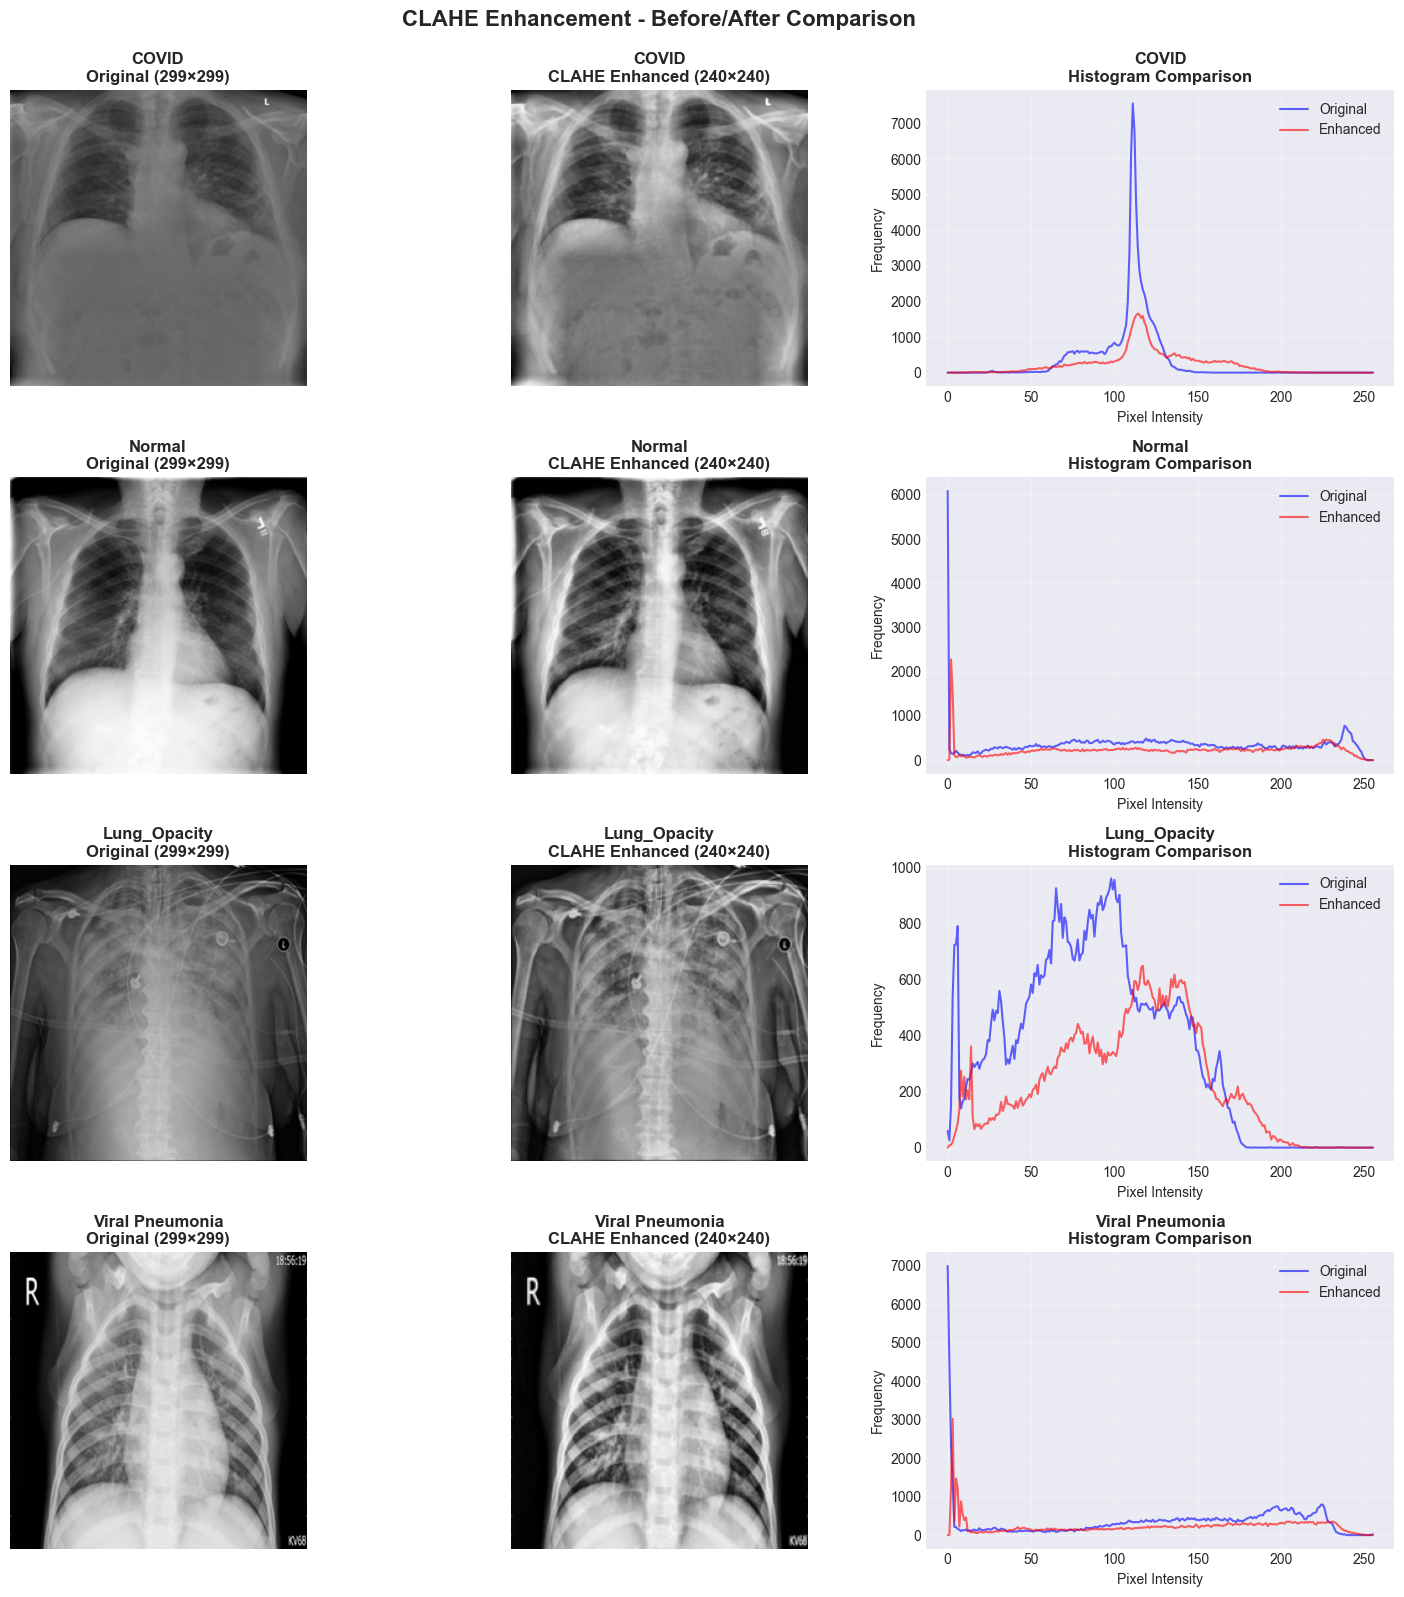


✅ CLAHE enhancement test complete

💡 Observations:
   - Enhanced images show improved contrast
   - Histogram equalization spreads pixel intensity distribution
   - Image size reduced from 299×299 to 240×240


In [5]:
print("=" * 70)
print("TESTING CLAHE ENHANCEMENT")
print("=" * 70)

# Sample one image from each class
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

for idx, class_name in enumerate(class_names):
    # Get one sample from this class
    sample = train_df[train_df['class_name'] == class_name].iloc[0]
    
    # Load original image
    original = cv2.imread(sample['image_path'], cv2.IMREAD_GRAYSCALE)
    
    # Apply CLAHE
    enhanced_rgb, success, error = preprocess_image(sample['image_path'])
    
    if success:
        # Convert RGB back to grayscale for visualization
        enhanced_gray = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2GRAY)
        
        # Calculate histogram
        hist_original = cv2.calcHist([original], [0], None, [256], [0, 256])
        hist_enhanced = cv2.calcHist([enhanced_gray], [0], None, [256], [0, 256])
        
        # Display original
        axes[idx, 0].imshow(original, cmap='gray')
        axes[idx, 0].set_title(f"{class_name}\nOriginal (299×299)", fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Display enhanced
        axes[idx, 1].imshow(enhanced_gray, cmap='gray')
        axes[idx, 1].set_title(f"{class_name}\nCLAHE Enhanced (240×240)", fontweight='bold')
        axes[idx, 1].axis('off')
        
        # Display histogram comparison
        axes[idx, 2].plot(hist_original, color='blue', alpha=0.6, label='Original')
        axes[idx, 2].plot(hist_enhanced, color='red', alpha=0.6, label='Enhanced')
        axes[idx, 2].set_title(f"{class_name}\nHistogram Comparison", fontweight='bold')
        axes[idx, 2].set_xlabel('Pixel Intensity')
        axes[idx, 2].set_ylabel('Frequency')
        axes[idx, 2].legend(loc='upper right')
        axes[idx, 2].grid(alpha=0.3)

plt.suptitle('CLAHE Enhancement - Before/After Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✅ CLAHE enhancement test complete")
print("\n💡 Observations:")
print("   - Enhanced images show improved contrast")
print("   - Histogram equalization spreads pixel intensity distribution")
print("   - Image size reduced from 299×299 to 240×240")
print("=" * 70)

## 6. Process Training Set

Apply CLAHE enhancement to all training images with progress tracking.

In [6]:
def process_dataset(df, split_name, output_base_dir):
    """
    Process entire dataset split with CLAHE enhancement.
    
    Args:
        df (pd.DataFrame): DataFrame with image paths and labels
        split_name (str): Name of split ('train', 'val', 'test')
        output_base_dir (Path): Base directory for output
    
    Returns:
        tuple: (processed_count, failed_count, failed_files)
    """
    print(f"\n{'='*70}")
    print(f"PROCESSING {split_name.upper()} SET")
    print(f"{'='*70}")
    
    processed_count = 0
    failed_count = 0
    failed_files = []
    
    # Process each image
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        # Get original image path
        original_path = Path(row['image_path'])
        
        # Create output path
        class_name = row['class_name']
        output_dir = output_base_dir / split_name / class_name
        output_path = output_dir / original_path.name
        
        # Apply CLAHE enhancement
        enhanced_img, success, error = preprocess_image(original_path)
        
        if success:
            # Save enhanced image
            # Convert RGB to BGR for cv2.imwrite
            enhanced_bgr = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(str(output_path), enhanced_bgr)
            processed_count += 1
        else:
            failed_count += 1
            failed_files.append({'path': str(original_path), 'error': error})
    
    # Print summary
    print(f"\n✅ {split_name.upper()} Processing Complete:")
    print(f"   - Processed: {processed_count:,} images")
    print(f"   - Failed:    {failed_count:,} images")
    print(f"   - Success Rate: {processed_count/(processed_count+failed_count)*100:.2f}%")
    
    return processed_count, failed_count, failed_files


# Process training set
train_processed, train_failed, train_failures = process_dataset(train_df, 'train', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING TRAIN SET


Processing train: 100%|██████████| 16931/16931 [02:25<00:00, 116.59it/s]


✅ TRAIN Processing Complete:
   - Processed: 16,931 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 7. Process Validation Set

Apply CLAHE enhancement to all validation images.

In [7]:
# Process validation set
val_processed, val_failed, val_failures = process_dataset(val_df, 'val', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING VAL SET


Processing val: 100%|██████████| 2117/2117 [00:17<00:00, 119.43it/s]


✅ VAL Processing Complete:
   - Processed: 2,117 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 8. Process Test Set

Apply CLAHE enhancement to all test images.

In [8]:
# Process test set
test_processed, test_failed, test_failures = process_dataset(test_df, 'test', OUTPUT_DIR)

print("\n" + "=" * 70)


PROCESSING TEST SET


Processing test: 100%|██████████| 2117/2117 [00:16<00:00, 126.66it/s]


✅ TEST Processing Complete:
   - Processed: 2,117 images
   - Failed:    0 images
   - Success Rate: 100.00%



## 9. Validation & Quality Checks

Verify processed images and check for issues.

In [9]:
print("=" * 70)
print("QUALITY VALIDATION")
print("=" * 70)

# Check if any files failed
total_failed = train_failed + val_failed + test_failed

if total_failed > 0:
    print(f"\n⚠️  WARNING: {total_failed} images failed processing")
    print("\nFailed files:")
    all_failures = train_failures + val_failures + test_failures
    for fail in all_failures[:10]:  # Show first 10
        print(f"   - {fail['path']}: {fail['error']}")
    if len(all_failures) > 10:
        print(f"   ... and {len(all_failures) - 10} more")
else:
    print("\n✅ All images processed successfully!")

# Verify random samples
print("\n🔍 Verifying random samples...")
verification_count = 0
verification_samples = 10

for split_name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    samples = df.sample(n=min(verification_samples, len(df)), random_state=SEED)
    
    for _, row in samples.iterrows():
        output_path = OUTPUT_DIR / split_name / row['class_name'] / Path(row['image_path']).name
        
        if output_path.exists():
            # Verify image can be loaded and has correct dimensions
            img = cv2.imread(str(output_path))
            if img is not None and img.shape == (TARGET_SIZE[0], TARGET_SIZE[1], 3):
                verification_count += 1

total_verification = verification_samples * 3  # 3 splits
print(f"   ✓ Verified: {verification_count}/{total_verification} samples")
print(f"   ✓ All verified images have correct shape: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}×3")

print("\n" + "=" * 70)

QUALITY VALIDATION

✅ All images processed successfully!

🔍 Verifying random samples...
   ✓ Verified: 30/30 samples
   ✓ All verified images have correct shape: 240×240×3



## 10. Update CSV Files with Processed Paths

Create new CSV files with paths to CLAHE-enhanced images.

In [10]:
print("=" * 70)
print("UPDATING CSV FILES")
print("=" * 70)

def create_processed_csv(df, split_name, output_base_dir):
    """
    Create CSV with paths to processed images.
    
    Args:
        df (pd.DataFrame): Original DataFrame
        split_name (str): Name of split
        output_base_dir (Path): Base directory for processed images
    
    Returns:
        pd.DataFrame: Updated DataFrame with processed paths
    """
    df_copy = df.copy()
    
    # Update image paths to point to processed images
    processed_paths = []
    for _, row in df_copy.iterrows():
        original_filename = Path(row['image_path']).name
        processed_path = output_base_dir / split_name / row['class_name'] / original_filename
        processed_paths.append(str(processed_path.absolute()))
    
    df_copy['processed_path'] = processed_paths
    
    return df_copy


# Create updated DataFrames
train_processed_df = create_processed_csv(train_df, 'train', OUTPUT_DIR)
val_processed_df = create_processed_csv(val_df, 'val', OUTPUT_DIR)
test_processed_df = create_processed_csv(test_df, 'test', OUTPUT_DIR)

# Save to CSV
train_processed_df.to_csv(CSV_DIR / "train_processed.csv", index=False)
val_processed_df.to_csv(CSV_DIR / "val_processed.csv", index=False)
test_processed_df.to_csv(CSV_DIR / "test_processed.csv", index=False)

print("\n💾 Updated CSV files saved:")
print(f"   ✓ train_processed.csv ({len(train_processed_df):,} images)")
print(f"   ✓ val_processed.csv ({len(val_processed_df):,} images)")
print(f"   ✓ test_processed.csv ({len(test_processed_df):,} images)")

print(f"\n📂 Location: {CSV_DIR.absolute()}")

print("\n📋 Sample from train_processed.csv:")
print(train_processed_df[['class_name', 'label', 'processed_path']].head())

print("\n" + "=" * 70)

UPDATING CSV FILES

💾 Updated CSV files saved:
   ✓ train_processed.csv (16,931 images)
   ✓ val_processed.csv (2,117 images)
   ✓ test_processed.csv (2,117 images)

📂 Location: d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

📋 Sample from train_processed.csv:
     class_name  label                                     processed_path
0  Lung_Opacity      2  d:\Users\USER\Documents\GitHub\fyp-project\FYP...
1        Normal      1  d:\Users\USER\Documents\GitHub\fyp-project\FYP...
2  Lung_Opacity      2  d:\Users\USER\Documents\GitHub\fyp-project\FYP...
3  Lung_Opacity      2  d:\Users\USER\Documents\GitHub\fyp-project\FYP...
4        Normal      1  d:\Users\USER\Documents\GitHub\fyp-project\FYP...



## 11. Storage Statistics

Calculate disk space usage for processed images.

In [11]:
print("=" * 70)
print("STORAGE STATISTICS")
print("=" * 70)

def get_directory_size(directory):
    """Calculate total size of directory in bytes."""
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.exists(filepath):
                total_size += os.path.getsize(filepath)
    return total_size


# Calculate sizes
train_size = get_directory_size(OUTPUT_DIR / 'train')
val_size = get_directory_size(OUTPUT_DIR / 'val')
test_size = get_directory_size(OUTPUT_DIR / 'test')
total_size = train_size + val_size + test_size

print("\n💾 Storage Usage:")
print(f"   - Train Set: {train_size / 1024**2:.2f} MB ({train_processed:,} images)")
print(f"   - Val Set:   {val_size / 1024**2:.2f} MB ({val_processed:,} images)")
print(f"   - Test Set:  {test_size / 1024**2:.2f} MB ({test_processed:,} images)")
print(f"   - TOTAL:     {total_size / 1024**2:.2f} MB ({train_processed + val_processed + test_processed:,} images)")

print(f"\n📂 Processed images location: {OUTPUT_DIR.absolute()}")

print("\n" + "=" * 70)

STORAGE STATISTICS

💾 Storage Usage:
   - Train Set: 1528.55 MB (16,931 images)
   - Val Set:   190.96 MB (2,117 images)
   - Test Set:  190.82 MB (2,117 images)
   - TOTAL:     1910.34 MB (21,165 images)

📂 Processed images location: d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced



## 12. Summary Report

Final summary of data cleaning and preprocessing.

In [12]:
print("\n" + "=" * 70)
print("DATA CLEANING SUMMARY REPORT")
print("=" * 70)

print("\n✅ COMPLETED TASKS:")
print("   [✓] Applied CLAHE enhancement to all images")
print(f"   [✓] Resized images from 299×299 to {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   [✓] Converted grayscale to RGB (3 channels)")
print("   [✓] Validated image quality")
print("   [✓] Saved processed images with organized structure")
print("   [✓] Updated CSV files with processed paths")

print("\n📊 PROCESSING STATISTICS:")
total_processed = train_processed + val_processed + test_processed
total_images = len(train_df) + len(val_df) + len(test_df)
success_rate = (total_processed / total_images) * 100 if total_images > 0 else 0

print(f"   - Total Images: {total_images:,}")
print(f"   - Successfully Processed: {total_processed:,}")
print(f"   - Failed: {total_failed:,}")
print(f"   - Success Rate: {success_rate:.2f}%")

print("\n🔧 PREPROCESSING APPLIED:")
print(f"   - CLAHE Clip Limit: {CLAHE_CLIP_LIMIT}")
print(f"   - CLAHE Tile Grid: {CLAHE_TILE_GRID_SIZE}")
print(f"   - Target Size: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")
print("   - Color Space: RGB (3 channels)")

print("\n📁 OUTPUT FILES:")
print("   CSV Files:")
print("   - train_processed.csv")
print("   - val_processed.csv")
print("   - test_processed.csv")
print(f"   📂 {CSV_DIR.absolute()}")
print("\n   Processed Images:")
print("   - train/ (CLAHE enhanced)")
print("   - val/ (CLAHE enhanced)")
print("   - test/ (CLAHE enhanced)")
print(f"   📂 {OUTPUT_DIR.absolute()}")

print("\n🎯 NEXT STEPS:")
print("   1. Proceed to 03_eda.ipynb")
print("   2. Analyze class distributions and image statistics")
print("   3. Explore pixel intensity distributions")
print("   4. Generate correlation studies")

print("\n✅ Data cleaning phase complete! Ready for EDA.")
print("=" * 70 + "\n")


DATA CLEANING SUMMARY REPORT

✅ COMPLETED TASKS:
   [✓] Applied CLAHE enhancement to all images
   [✓] Resized images from 299×299 to 240×240
   [✓] Converted grayscale to RGB (3 channels)
   [✓] Validated image quality
   [✓] Saved processed images with organized structure
   [✓] Updated CSV files with processed paths

📊 PROCESSING STATISTICS:
   - Total Images: 21,165
   - Successfully Processed: 21,165
   - Failed: 0
   - Success Rate: 100.00%

🔧 PREPROCESSING APPLIED:
   - CLAHE Clip Limit: 2.0
   - CLAHE Tile Grid: (8, 8)
   - Target Size: 240×240
   - Color Space: RGB (3 channels)

📁 OUTPUT FILES:
   CSV Files:
   - train_processed.csv
   - val_processed.csv
   - test_processed.csv
   📂 d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed

   Processed Images:
   - train/ (CLAHE enhanced)
   - val/ (CLAHE enhanced)
   - test/ (CLAHE enhanced)
   📂 d:\Users\USER\Documents\GitHub\fyp-project\FYP_Code\notebooks\..\data\processed\clahe_enhanced

🎯 NEXT STE